In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45


from torch.autograd.functional import jacobian
import random



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


# Pendelum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [2]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.arange(0, 10, 0.01)

sol = odeint(pend,y0, t, args=(b,c))


In [3]:
theta = 2*np.pi - sol[:, 0]
omega = sol[:, 1]

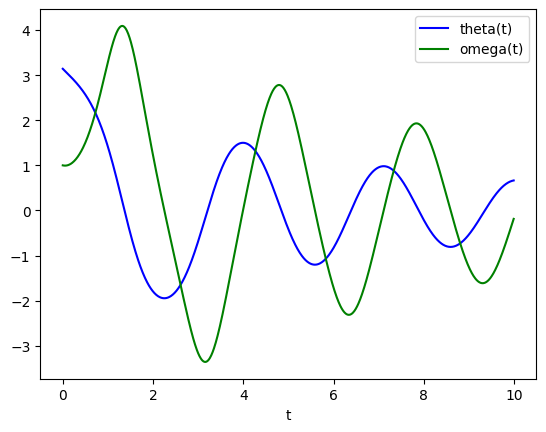

In [4]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

# Neural ODE with ajoint-sensitivity-method

$$
x: \mathbb{R} \rightarrow  \mathbb{R}^{N_1 \times N_2} \\
N_1 \ldots \text{size of batch} \\
N_2 \ldots \text{size of vector} \\
x^i_j \equiv x(t) \\
$$
$$
\mathcal{L} : \mathbb{R}^{N_1 \times N_2} \times \underbrace{\mathbb{R}^{N_1 \times N_2}}_{\text{prediction}}  \rightarrow \mathbb{R} \\
$$
$$
a^i_j \equiv a = \frac{\partial \mathcal{L}}{\partial x(t)} \\
\dot x = f(x(t), p^a) \\

\frac{da}{dt} = - a^T \frac{\partial f}{\partial x} \\

\frac{d\mathcal{L}}{dp^a} = - \int_{t_1}^{t_0} dt \sum_i \sum_j a^j_i \frac{\partial f^i_j}{\partial p^a } = - N_1 \ N_2 \int dt \ \frac{\partial}{\partial p^a}   mean(a(t) * f(x(t)))
$$

$$
= - N_1 \ N_2 * \sum_n \frac{\partial}{\partial p^a} mean(a_n * f(x_n))
$$

$$
x_n = \text{from ode solve last x at last point} \\
\text{loop : } \\ 
x_{n-1} = x_n - \Delta t * f(x_n, p)
$$

$$
a_n = \text{at last point} \\
\text{loop : } \\ 
a_{n-1} = a_n - \Delta t * f(x_n, p)
$$



In [5]:
def ode_solve(func, x, propagation_time, delta_t, return_seq=False):
    """
    solves the differential equation : dx/dt = f(x(t)) using eulers method

    Parameters
    ----------
    func :  python function
            Parameters
            ----------
            x : torch.Tensor    

            Returns
            -------
            torch.Tensor
    
    x : torch.Tensor
        input for func (singlet or whole batch)

    propagation_time : float
    delta_t : float 
        accuracy of solution
    return_seq : bool
        flag for returning whole sequence or not

    
    Returns
    -------
    torch.tensor

    """
    time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
    x = x.clone().detach()
    if not return_seq:
        for t in time:
            x = x + delta_t * func(x)
        return x
    if return_seq:
        outputs = torch.zeros(time.shape[0], x.shape[1])
        for i,_ in enumerate(time):
            x = x + delta_t * func(x)
            outputs[i] = x
        return outputs

In [110]:
class PendelumNetwork(nn.Module):
    def __init__(self):
        super(PendelumNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 10, dtype=float),
            nn.Sigmoid(),
            nn.Linear(10, 2, dtype=float)
        )
    def forward(self,x): 
        """implements f(x)
        x = (theta, omega)
        theta ... angle
        omega ... angular velocity

        Parameters
        ----------
        x : torch.tensor 
            shape = (2,N)

        Returns
        -------
        torch.tensor

        """
        return self.linear_relu_stack(x)

    def flatten_parameters(self):
        """
        Returns
        -------
        torch.Tensor: 
            flat parameters
        """
        flat_parameters = []
        for p in self.parameters():
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

    def get_adfdp(self, x , a ):
        """
        Parameters
        ----------
        x : torch.Tensor
        a : torch.Tensor
            same shape as x

        Returns
        -------
        torch.Tensor : 
            a * df/dp ... p = Network parameters
        """
        with torch.enable_grad():

            temp = torch.mean( a.detach().T @ self.forward(x.requires_grad_(True)))
            temp.backward(retain_graph=True)
            grads = []
            for param in self.parameters():
                grads.append(param.grad.view(-1))
            grads = torch.cat(grads)

            for param in self.parameters():
                param.grad.zero_() #clears accumulation
            return grads
        

In [45]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, flat_parameters, func, delta_t, propagation_time, return_seq=False):
        
        if return_seq:
            return ode_solve(func, x,  propagation_time, delta_t, return_seq)
        else:
            output = ode_solve(func, x, propagation_time, delta_t, return_seq)
            ctx.func = func
            ctx.delta_t = delta_t
            ctx.propagation_time = propagation_time
            ctx.save_for_backward(output.clone(), flat_parameters)


            return output
        
    @staticmethod
    def backward(ctx, dL_dz):

        func = ctx.func
        delta_t = ctx.delta_t
        propagation_time = ctx.propagation_time
        x_1 , flat_parameters = ctx.saved_tensors
        a_1 =  (-1) * dL_dz.detach() 

        def one_adjoint_backward_step(func, x_1, a_1, delta_t):
            a = a_1.clone().detach()
            x = x_1.clone().detach().requires_grad_(True) #new graph drop old graph
            with torch.enable_grad():
                outputs = func(x)
                a -= delta_t * torch.autograd.grad(outputs=outputs, inputs=x, grad_outputs=a)[0]
                return a

        def one_euler_backward_step(func,x_1, delta_t):
            x = x_1.clone().detach()
            x -= delta_t * func(x)
            return x

        def get_dL_dp(func, a_1, x_1, delta_t):
            time = torch.arange(start=0, end=propagation_time, step=delta_t, requires_grad=False)
            a = a_1.clone().detach() 
            x = x_1.clone().detach()
            result = torch.zeros(func.flatten_parameters().shape)
            for t in time:
                result -= delta_t * func.get_adfdp(x,a)
                a = one_adjoint_backward_step(func, x, a, delta_t).clone().detach()
                x = one_euler_backward_step(func, x,delta_t).clone().detach()
            return result

        return None, get_dL_dp(func,a_1,x_1,delta_t), None, None, None, None

In [54]:
class NeuralODE(nn.Module):
    def __init__(self, func, delta_t):
        super(NeuralODE, self).__init__()
        self.func = func
        self.delta_t = delta_t
    
    def forward(self, x, propagation_time, return_seq=False, use_adjoint = True):
        if use_adjoint:
            return ODEAdjoint.apply(x, self.func.flatten_parameters(), self.func, self.delta_t , propagation_time, return_seq)
        else:
            return ode_solve(self.func, x,  propagation_time, self.delta_t, return_seq)
           
        

In [9]:
def create_data_set(theta, omega, propagation_index=25, number_of_samples=200):
    """ x_i -> x_f
        x_i ... initial state
        x_f ... final state
        x_i = [theta_i, omega_i]
        x_f = [theta_f, omega_f]
        data_set = [[x_i, x_f]
                    [...]
                    ...
                    ]

    Parameters
    ----------
    theta : np.array or torch.tensor
        angle
    omega : np.array or torch.tensor
        angular velocity
   
    propagation_index : int
    
    number_of_samples : int
    
    Returns
    -------
    torch.tensor
    """
    x_i = []
    x_f = []
    data_set = torch.zeros((2,number_of_samples,2), dtype=float)
    while len(x_i) < number_of_samples:

        index = int(random.uniform(0, len(theta))) #selectes random index

        if index+propagation_index >= len(theta):
            continue

        x_i.append([theta[index], omega[index]])
        x_f.append([theta[index+propagation_index], omega[index+propagation_index]])
    x_i = torch.tensor(x_i)
    x_f = torch.tensor(x_f)
    data_set[0][:] = x_i
    data_set[1][:] = x_f
    return data_set.T

In [10]:
def create_batches(data_set, batch_size=64):
    """
    creates batches
    data is not shuffled and dropes last batch if size would be smaller than batch_size

    Parameters
    ----------
    data_set : troch.tensor 
        data_set[0] ... input
        data_set[1] ... output
    
        shape = (2,N_1,N_2)
        N_1 ... number of samples
        N_2 ... size of vector

    batch_size : int

    Retruns
    -------
    troch.tensor
    

    """
    number_of_batches = int(data_set.shape[1]/batch_size)
    batches = torch.zeros((number_of_batches,2,batch_size,data_set.shape[2]), dtype=float)
    for i in range(number_of_batches-1):
        batch = torch.zeros((2,batch_size,data_set.shape[2]), dtype=float)
        batch[0] = data_set[0][i*batch_size:(i+1)*batch_size][:]
        batch[1] = data_set[1][i*batch_size:(i+1)*batch_size][:] 
        batches[i] = batch
    
    return batches[:int(number_of_batches*0.75)], batches[int(number_of_batches*0.75):]


In [129]:
propagation_index = 30
propagation_time = t[propagation_index]
print(propagation_time)
data_set = create_data_set(theta=theta, omega=omega, propagation_index=25, number_of_samples=64*5)
train, test = create_batches(data_set, 64)
print(train.shape)
print(test.shape)


0.3
torch.Size([3, 2, 64, 2])
torch.Size([2, 2, 64, 2])


In [135]:
#training
epoch = 500
delta_t = 0.01

func = PendelumNetwork()
model = NeuralODE(func, delta_t)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for k in range(epoch):
    avg_los = []
    for train_batch in train:
        x_i, x_f = train_batch
        prediction = model(x_i, propagation_time, use_adjoint = False)
       
        loss = torch.mean(torch.norm((prediction - x_f),dim=1)**2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_los.append(loss.item())
    if (k+1)%10==0:
        avg_los_2 = []
        for test_batch in test:
            x_i, x_f = test_batch
            prediction = model(x_i, propagation_time, use_adjoint=False)
            print(torch.norm((prediction - x_f),dim=1)**2)
            break
            loss = torch.mean(torch.norm((prediction - x_f),dim=1)**2)
            avg_los_2.append(loss.item())

        print(k+1 , "\t training ",np.mean(avg_los))
        print(" \t validation ",np.mean(avg_los_2))
        print("_________")


tensor([[ 3.2148,  3.5213],
        [-2.5903, -1.9096],
        [-4.1069, -4.0488],
        [ 1.9009,  1.2220],
        [ 3.2402,  3.5108],
        [-2.7330, -2.7784],
        [ 1.2889,  0.7729],
        [ 2.3473,  2.0933],
        [-3.2645, -4.1737],
        [ 2.3494,  1.4534],
        [ 2.1319,  2.4574],
        [-1.8065, -1.9580],
        [-2.2930, -1.4527],
        [-3.9463, -3.3063],
        [-1.8839, -1.4437],
        [ 1.7838,  0.7683],
        [ 1.3936,  2.2417],
        [-0.4413,  0.4476],
        [ 3.2327,  2.6679],
        [-0.3610, -1.2434],
        [ 1.0015,  0.0992],
        [ 2.3420,  2.0673],
        [-4.1069, -4.0488],
        [ 2.2160,  1.7370],
        [-1.8176, -1.3001],
        [ 1.7850,  1.0600],
        [ 2.2142,  2.4361],
        [ 0.4521,  1.2416],
        [ 0.7281, -0.1791],
        [-2.5675, -1.8704],
        [ 1.7287,  1.6475],
        [-1.9543, -1.7090],
        [ 1.8754,  3.1327],
        [-1.6174, -1.9634],
        [-1.9347, -1.8499],
        [ 1.5583,  2

c:\Users\z004m34v\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\z004m34v\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


tensor([[ 3.1939,  3.5456],
        [-2.3200, -1.7977],
        [-3.8921, -3.9501],
        [ 1.7273,  1.2119],
        [ 3.2111,  3.5331],
        [-2.5919, -2.7007],
        [ 0.9307,  0.7085],
        [ 2.2484,  2.1005],
        [-3.2696, -4.1312],
        [ 2.0775,  1.4182],
        [ 2.1578,  2.4952],
        [-1.7206, -1.8963],
        [-2.0035, -1.3354],
        [-3.6180, -3.1755],
        [-1.6863, -1.3531],
        [ 1.5082,  0.7324],
        [ 1.5442,  2.3129],
        [-0.2166,  0.5430],
        [ 3.0160,  2.6457],
        [-0.4779, -1.2354],
        [ 0.8176,  0.0879],
        [ 2.2390,  2.0735],
        [-3.8921, -3.9501],
        [ 2.0740,  1.7341],
        [-1.6084, -1.2066],
        [ 1.6059,  1.0487],
        [ 2.2169,  2.4680],
        [ 0.6261,  1.3211],
        [ 0.3809, -0.2381],
        [-2.2950, -1.7580],
        [ 1.3648,  1.5790],
        [-1.7894, -1.6269],
        [ 2.0829,  3.2186],
        [-1.5756, -1.9131],
        [-1.8000, -1.7756],
        [ 1.6879,  2

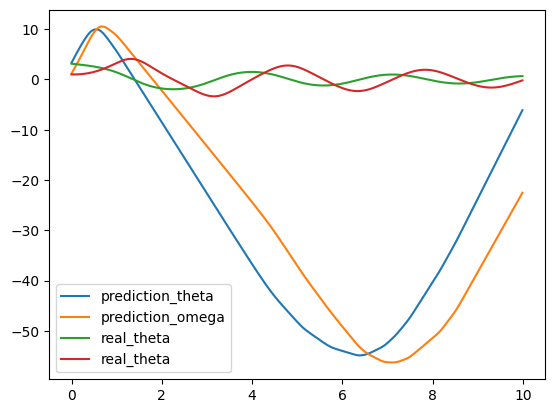

In [134]:
prediction_theta = model(torch.tensor([[theta[0], omega[0]]],dtype=float), 10, True).T[0].detach().numpy()
prediction_omega = model(torch.tensor([[theta[0], omega[0]]],dtype=float), 10, True).T[1].detach().numpy()

plt.plot(np.arange(0, 10, delta_t),prediction_theta, label="prediction_theta")
plt.plot(np.arange(0, 10, delta_t),prediction_omega, label="prediction_omega")
plt.plot(t, theta,label="real_theta")
plt.plot(t, omega,label="real_theta")
plt.legend()
plt.show()